<a href="https://colab.research.google.com/github/HambaliMarcel/domainscan-surrounding-poc/blob/main/deep_analysis_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests python-whois ipwhois geopy bs4 cryptography pandas matplotlib networkx dnspython
!pip install googlesearch-python
!pip install scikit-learn
!git clone https://github.com/aboul3la/Sublist3r.git
!pip install -r Sublist3r/requirements.txt

import requests
import whois
from ipwhois import IPWhois
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import socket
import ssl
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dns.resolver
import re
import warnings
import subprocess
import os
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from IPython.display import display

warnings.filterwarnings('ignore')
def run_sublist3r(domain):
    if not os.path.exists('Sublist3r'):
        subprocess.run('git clone https://github.com/aboul3la/Sublist3r.git', shell=True)
    command = f"python Sublist3r/sublist3r.py -d {domain} -o sublist3r_output.txt"
    subprocess.run(command, shell=True, check=True)
    with open("sublist3r_output.txt", "r") as file:
        subdomains = file.read().splitlines()
    return subdomains
def dnsdumpster_search(domain):
    response = requests.get(f"https://api.hackertarget.com/hostsearch/?q={domain}")
    if response.status_code == 200:
        subdomains = [line.split(",")[0] for line in response.text.splitlines()]
    else:
        subdomains = []
    return subdomains
def aggregate_subdomains(*args):
    all_subdomains = set()
    for sublist in args:
        all_subdomains.update(sublist)
    return sorted(all_subdomains)

def check_dns_resolution(subdomains):
    resolved_subdomains = []
    for subdomain in subdomains:
        try:
            dns.resolver.resolve(subdomain, 'A')
            resolved_subdomains.append(subdomain)
        except (dns.resolver.NXDOMAIN, dns.resolver.NoAnswer, dns.resolver.Timeout):
            continue
        except Exception as e:
            continue
    return resolved_subdomains

def is_live(subdomain):
    for protocol in ['https://', 'http://']:
        try:
            response = requests.get(f'{protocol}{subdomain}', timeout=10, verify=False)
            if response.status_code == 200:
                return protocol
        except:
            continue
    return None
def get_ssl_certificate(subdomain):
    ctx = ssl.create_default_context()
    s = ctx.wrap_socket(socket.socket(), server_hostname=subdomain)
    try:
        s.settimeout(5)
        s.connect((subdomain, 443))
        cert_bin = s.getpeercert(True)
        cert = x509.load_der_x509_certificate(cert_bin, default_backend())
        issuer = cert.issuer.rfc4514_string()
        subject = cert.subject.rfc4514_string()
        valid_from = cert.not_valid_before.strftime('%Y-%m-%d')
        valid_until = cert.not_valid_after.strftime('%Y-%m-%d')
        return {
            'issuer': issuer,
            'subject': subject,
            'valid_from': valid_from,
            'valid_until': valid_until
        }
    except:
        return None

def get_geolocation(ip_address):
    try:
        response = requests.get(f'https://ipapi.co/{ip_address}/json/', timeout=5)
        data = response.json()
        city = data.get('city')
        region = data.get('region')
        country = data.get('country_name')
        if city and region and country:
            return f"{city}, {region}, {country}"
        elif country:
            return country
        else:
            return 'Location not found'
    except:
        return 'Error retrieving location'

def get_dns_records(subdomain):
    records = {}
    try:
        answers = dns.resolver.resolve(subdomain, 'A', lifetime=5)
        records['A'] = [r.to_text() for r in answers]
    except:
        records['A'] = []
    try:
        answers = dns.resolver.resolve(subdomain, 'MX', lifetime=5)
        records['MX'] = [r.exchange.to_text() for r in answers]
    except:
        records['MX'] = []
    try:
        answers = dns.resolver.resolve(subdomain, 'NS', lifetime=5)
        records['NS'] = [r.to_text() for r in answers]
    except:
        records['NS'] = []
    return records

technology_categories = {
    'Web Servers': 'Server',
    'Programming Languages': 'Backend',
    'Frameworks': 'Backend',
    'JavaScript Libraries': 'Frontend',
    'Content Management Systems': 'Backend',
    'Web Frameworks': 'Backend',
    'Operating Systems': 'Server',
    'Databases': 'Backend',
    'Analytics': 'Libraries/3rd Party',
    'Widgets': 'Frontend',
    'Font Scripts': 'Frontend',
    'Tag Managers': 'Libraries/3rd Party',
    'SSL Certificates': 'Certificates',
    'CDN': 'Network',
    'Reverse Proxy': 'Network',
    'Load Balancers': 'Network',
    'Email Hosting Providers': 'Network',
    'DNS Servers': 'Network',
    'Advertising Networks': 'Libraries/3rd Party',
    # add
}

technology_signatures = {
    'Web Servers': {
        'Nginx': {'headers': {'Server': r'nginx'}},
        'Apache': {'headers': {'Server': r'Apache'}},
        'IIS': {'headers': {'Server': r'Microsoft-IIS'}},
    },
    'Programming Languages': {
        'PHP': {'headers': {'X-Powered-By': r'PHP'}},
        'Python': {'text': [r'django', r'python']},
        'Ruby': {'headers': {'X-Powered-By': r'Ruby'}},
    },
    'JavaScript Libraries': {
        'jQuery': {'scripts': [r'jquery.*\.js']},
        'React': {'scripts': [r'react.*\.js'], 'text': [r'__REACT_DEVTOOLS_GLOBAL_HOOK__']},
        'AngularJS': {'scripts': [r'angular.*\.js'], 'attributes': ['ng-app', 'ng-controller']},
    },
    'Content Management Systems': {
        'WordPress': {'meta_generator': [r'WordPress'], 'scripts': [r'wp-includes']},
        'Drupal': {'meta_generator': [r'Drupal'], 'scripts': [r'drupal\.js']},
    },
    'SSL Certificates': {
        "Let's Encrypt": {'ssl_issuer': [r"Let's Encrypt"]},
    },
    # addd
}

def detect_technologies(response, content, ssl_info):
    detected_technologies = {}
    soup = BeautifulSoup(content, 'html.parser')
    for category, techs in technology_signatures.items():
        mapped_category = technology_categories.get(category, 'Others')
        detected_technologies.setdefault(mapped_category, [])
        for tech_name, signatures in techs.items():
            found = False
            if 'headers' in signatures:
                for header, pattern in signatures['headers'].items():
                    header_value = response.headers.get(header, '')
                    if re.search(pattern, header_value, re.IGNORECASE):
                        found = True
                        break
            if not found and 'meta_generator' in signatures:
                meta_tag = soup.find('meta', attrs={'name': 'generator'})
                if meta_tag and any(re.search(pat, meta_tag.get('content', ''), re.IGNORECASE) for pat in signatures['meta_generator']):
                    found = True
            if not found and 'scripts' in signatures:
                scripts = soup.find_all('script', src=True)
                for script in scripts:
                    src = script['src']
                    if any(re.search(pat, src, re.IGNORECASE) for pat in signatures['scripts']):
                        found = True
                        break
            if not found and 'attributes' in signatures:
                for attr in signatures['attributes']:
                    if soup.find(attrs={attr: True}):
                        found = True
                        break
            if not found and 'text' in signatures:
                if any(re.search(pat, content.decode('utf-8', 'ignore'), re.IGNORECASE) for pat in signatures['text']):
                    found = True
            if not found and 'ssl_issuer' in signatures and ssl_info:
                issuer = ssl_info.get('issuer', '')
                if any(re.search(pat, issuer, re.IGNORECASE) for pat in signatures['ssl_issuer']):
                    found = True
            if found:
                if tech_name not in detected_technologies[mapped_category]:
                    detected_technologies[mapped_category].append(tech_name)
    return detected_technologies

deprecated_technologies = {
    'PHP': ['5.6', '7.0', '7.1'],
    'jQuery': ['1.7', '1.8', '1.9'],
    # add.
}

def identify_deprecated_technologies(technologies):
    deprecated = []
    for category, tech_list in technologies.items():
        for tech in tech_list:
            if ' ' in tech:
                tech_name, version = tech.split(' ', 1)
                if tech_name in deprecated_technologies and version in deprecated_technologies[tech_name]:
                    deprecated.append(f"{tech_name} {version}")
            else:
                if tech in deprecated_technologies:
                    deprecated.append(tech)
    return deprecated

recommended_security_headers = [
    'Strict-Transport-Security',
    'Content-Security-Policy',
    'X-Content-Type-Options',
    'X-Frame-Options',
    'X-XSS-Protection',
    'Referrer-Policy',
    'Permissions-Policy',
]

def identify_missing_security_headers(security_headers):
    missing = []
    for header in recommended_security_headers:
        if header not in security_headers:
            missing.append(header)
    return missing

def check_ssl_expiration(valid_until_str):
    try:
        valid_until = datetime.strptime(valid_until_str, '%Y-%m-%d')
        days_remaining = (valid_until - datetime.now()).days
        if days_remaining < 30:
            return f"SSL certificate expires in {days_remaining} days"
        else:
            return None
    except:
        return None

def generate_recommendations(row):
    recommendations = []
    if row['Deprecated Technologies']:
        recommendations.append(f"Update deprecated technologies: {', '.join(row['Deprecated Technologies'])}")
    if row['Missing Security Headers']:
        recommendations.append(f"Implement missing security headers: {', '.join(row['Missing Security Headers'])}")
    if row['SSL Expiration']:
        recommendations.append(row['SSL Expiration'])
    return recommendations

def cluster_subdomains(df):
    if df.empty:
        df['Cluster'] = []
        return df
    tech_strings = df['Technologies'].apply(lambda x: ' '.join([f"{cat}:{','.join(techs)}" for cat, techs in x.items()]))
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tech_strings)
    kmeans = KMeans(n_clusters=3, random_state=0)
    df['Cluster'] = kmeans.fit_predict(X)
    return df

def main(domain):
    print("Running Sublist3r...")
    sublist3r_results = run_sublist3r(domain)
    print("Fetching subdomains from DNSDumpster...")
    dnsdumpster_results = dnsdumpster_search(domain)
    all_subdomains = aggregate_subdomains(sublist3r_results, dnsdumpster_results)
    print(f"Total subdomains found: {len(all_subdomains)}")
    resolved_subdomains = check_dns_resolution(all_subdomains)
    print(f"Resolved subdomains: {len(resolved_subdomains)}")

    results = []

    for subdomain in resolved_subdomains:
        protocol = is_live(subdomain)
        if protocol:
            print(f'\nAnalyzing {subdomain} ({protocol})')
            data = {'Subdomain': subdomain, 'Protocol': protocol}
            try:
                domain_info = whois.whois(domain)
                owner = domain_info.get('org') or domain_info.get('name') or 'No owner info available'
                data['Owner'] = owner
            except:
                data['Owner'] = 'Error retrieving WHOIS info'
            ssl_info = get_ssl_certificate(subdomain)
            if ssl_info:
                data['SSL Issuer'] = ssl_info['issuer']
                data['SSL Subject'] = ssl_info['subject']
                data['SSL Valid From'] = ssl_info['valid_from']
                data['SSL Valid Until'] = ssl_info['valid_until']
            else:
                data['SSL Issuer'] = 'N/A'
                data['SSL Subject'] = 'N/A'
                data['SSL Valid From'] = 'N/A'
                data['SSL Valid Until'] = 'N/A'
            try:
                ip_address = socket.gethostbyname(subdomain)
                data['IP Address'] = ip_address
                location = get_geolocation(ip_address)
                data['Location'] = location
            except:
                data['IP Address'] = 'Error'
                data['Location'] = 'Error'
            try:
                response = requests.get(f'{protocol}{subdomain}', timeout=10, verify=False)
                data['Response Headers'] = dict(response.headers)
                security_headers = [
                    'Strict-Transport-Security',
                    'Content-Security-Policy',
                    'X-Content-Type-Options',
                    'X-Frame-Options',
                    'X-XSS-Protection',
                    'Referrer-Policy',
                    'Permissions-Policy',
                ]
                headers_info = {}
                for header in security_headers:
                    header_value = response.headers.get(header)
                    if header_value:
                        headers_info[header] = header_value
                data['Security Headers'] = headers_info
                content = response.content
            except:
                data['Response Headers'] = {}
                data['Security Headers'] = {}
                content = b''
            try:
                soup = BeautifulSoup(content, 'html.parser')
                title = soup.title.string.strip() if soup.title else 'No title available'
                description_tag = soup.find('meta', attrs={'name': 'description'})
                description = description_tag['content'].strip() if description_tag else 'No description available'
                data['Site Title'] = title
                data['Site Description'] = description
            except:
                data['Site Title'] = 'Error retrieving title'
                data['Site Description'] = 'Error retrieving description'
            tech_detected = detect_technologies(response, content, ssl_info)
            data['Technologies'] = tech_detected
            dns_records = get_dns_records(subdomain)
            data['DNS Records'] = dns_records
            results.append(data)
        else:
            print(f'\n{subdomain} is not live or not accessible.')
    df = pd.DataFrame(results)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    df.fillna('N/A', inplace=True)

    if df.empty:
        print("No live subdomains to analyze.")
        return

    columns_order = [
        'Subdomain', 'Protocol', 'Owner', 'IP Address', 'Location',
        'SSL Issuer', 'SSL Subject', 'SSL Valid From', 'SSL Valid Until',
        'Site Title', 'Site Description', 'Technologies', 'Security Headers',
        'DNS Records', 'Response Headers'
    ]
    df = df[columns_order]
    df['Deprecated Technologies'] = df['Technologies'].apply(identify_deprecated_technologies)
    df['Missing Security Headers'] = df['Security Headers'].apply(identify_missing_security_headers)
    df['SSL Expiration'] = df['SSL Valid Until'].apply(check_ssl_expiration)
    df['Recommendations'] = df.apply(generate_recommendations, axis=1)
    df = cluster_subdomains(df)
    df_display_columns = [
        'Subdomain', 'Owner', 'IP Address', 'Location',
        'Technologies', 'Deprecated Technologies', 'Missing Security Headers',
        'SSL Expiration', 'Recommendations', 'Cluster'
    ]
    display(df[df_display_columns])

domain = "pelindo.co.id"
main(domain)


fatal: destination path 'Sublist3r' already exists and is not an empty directory.
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Running Sublist3r...
Fetching subdomains from DNSDumpster...
Total subdomains found: 116
Resolved subdomains: 86

Analyzing airwatch.pelindo.co.id (http://)

ais.pelindo.co.id is not live or not accessible.

Analyzing api.pelindo.co.id (https://)

Analyzing badge-service-portaverse.pelindo.co.id (https://)

banjarmasin.pelindo.co.id is not live or not accessible.

Analyzing cctvonline.pelindo.co.id (http://)

Analyzing centra-dev.pelindo.co.id (https://)

Analyzing centra-fi.pelindo.co.id (https://)

Analyzing centra-qa.pelindo.co.id (https://)

Analyzing centra.pelindo.co.id (https://)

Analyzing cms-service-portaverse.pelindo.co.id (https://)

community-service-portaverse.pelindo.co.id is not live or not accessible.

Analyzing course-service-portaverse.pelindo.co.id (https://)

customerportal.pelindo.co.id is not live or not accessible.

Analyzing deponap4.pelindo.co.id (https://)

drone-tpm.pelindo.co.id is not live or not accessible.

Analyzing e-billing.pelindo.co.id (https://)

A

2024-09-14 09:30:56,722 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 104] Connection reset by peer
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 104] Connection reset by peer



Analyzing h2h-pelindo3.pelindo.co.id (https://)

helpdesk.pelindo.co.id is not live or not accessible.

Analyzing hq-service-portaverse.pelindo.co.id (https://)

Analyzing ibstpks.pelindo.co.id (https://)

ichange.pelindo.co.id is not live or not accessible.

ipchub-bot.pelindo.co.id is not live or not accessible.

ipchub-delivery.pelindo.co.id is not live or not accessible.

ipchub-emkl.pelindo.co.id is not live or not accessible.

ipchub-marine.pelindo.co.id is not live or not accessible.

ipchub-milestone.pelindo.co.id is not live or not accessible.

ipchub-receiving.pelindo.co.id is not live or not accessible.

ipchub-truck.pelindo.co.id is not live or not accessible.

ipchub-user.pelindo.co.id is not live or not accessible.

ipchub-utility.pelindo.co.id is not live or not accessible.

ipchub.pelindo.co.id is not live or not accessible.

Analyzing kmap-service-portaverse.pelindo.co.id (https://)

Analyzing knowledge-portaverse.pelindo.co.id (https://)

komersialtgperak.pelindo.co.

2024-09-14 09:35:07,358 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 104] Connection reset by peer
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 104] Connection reset by peer



tpkbelawan.pelindo.co.id is not live or not accessible.

training.pelindo.co.id is not live or not accessible.

Analyzing user-auth-service-portaverse.pelindo.co.id (https://)

Analyzing vasa.pelindo.co.id (https://)

vcprovision.pelindo.co.id is not live or not accessible.

Analyzing vessp4.pelindo.co.id (https://)

vicon.pelindo.co.id is not live or not accessible.

Analyzing webserver1.pelindo.co.id (http://)

webserver2.pelindo.co.id is not live or not accessible.

Analyzing www-dev.pelindo.co.id (https://)

Analyzing www.pelindo.co.id (https://)


,Subdomain,Owner,IP Address,Location,Technologies,Deprecated Technologies,Missing Security Headers,SSL Expiration,Recommendations,Cluster
0,airwatch.pelindo.co.id,No owner info available,103.41.110.36,"Kamal, East Java, Indonesia","{'Server': ['IIS'], 'Backend': [], 'Frontend': [], 'Certificates': []}",[],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",2
1,api.pelindo.co.id,No owner info available,103.41.110.114,"Kamal, East Java, Indonesia","{'Server': ['Nginx'], 'Backend': [], 'Frontend': [], 'Certificates': []}",[],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",0
2,badge-service-portaverse.pelindo.co.id,No owner info available,43.218.13.26,"Jakarta, Jakarta, Indonesia","{'Server': [], 'Backend': [], 'Frontend': [], 'Certificates': []}",[],"[Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Implement missing security headers: Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",2
3,cctvonline.pelindo.co.id,No owner info available,103.41.110.33,"Kamal, East Java, Indonesia","{'Server': ['IIS'], 'Backend': [], 'Frontend': [], 'Certificates': []}",[],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",2
4,centra-dev.pelindo.co.id,No owner info available,103.41.110.92,"Kamal, East Java, Indonesia","{'Server': ['Apache'], 'Backend': [], 'Frontend': ['jQuery'], 'Certificates': []}",[jQuery],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Update deprecated technologies: jQuery, Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",1
5,centra-fi.pelindo.co.id,No owner info available,103.41.110.92,"Kamal, East Java, Indonesia","{'Server': ['Apache'], 'Backend': [], 'Frontend': ['jQuery'], 'Certificates': []}",[jQuery],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Update deprecated technologies: jQuery, Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",1
6,centra-qa.pelindo.co.id,No owner info available,103.41.110.92,"Kamal, East Java, Indonesia","{'Server': ['Apache'], 'Backend': [], 'Frontend': [], 'Certificates': []}",[],"[Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",None,"[Implement missing security headers: Strict-Transport-Security, Content-Security-Policy, X-Content-Type-Options, X-Frame-Options, X-XSS-Protection, Referrer-Policy, Permissions-Policy]",1
7,centra.pelindo.co.id,No owner info available,103.41.110.92,"Kamal, East Java, Indonesia","{'Server': ['Apache'], 'Backend': [], 'Frontend': ['jQuery'], 'Certificates': []}",[jQuery],"[S

from matplotlib import pyplot as plt
_df_0['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Cluster'].plot(kind='line', figsize=(8, 4), title='Cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Cluster', y='Location', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

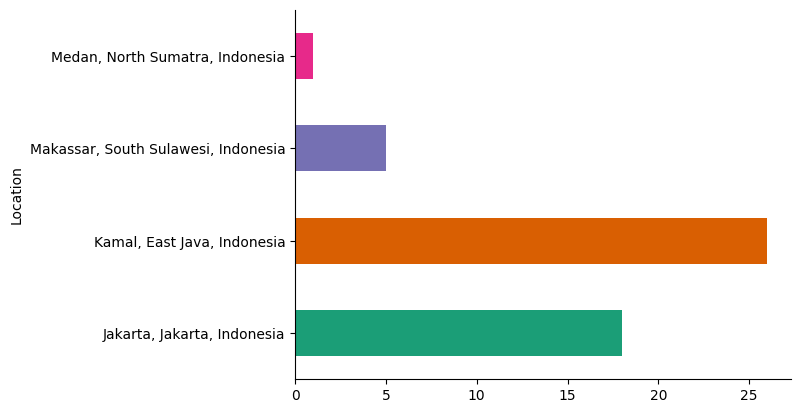

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

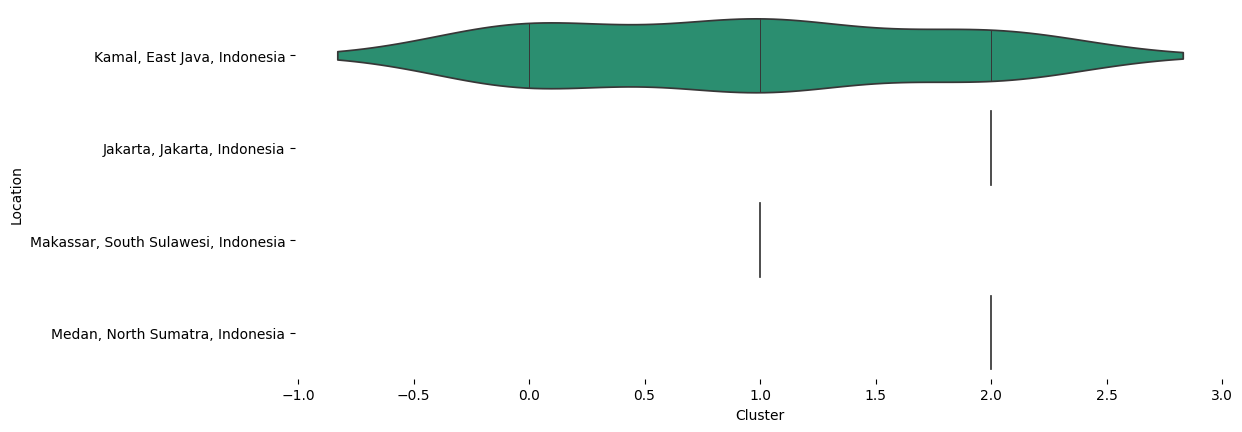

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Cluster', y='Location', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)